## Categorical Feature Encoding Challenge WITH PYTHON
[Crislânio Macêdo](https://medium.com/sapere-aude-tech) -  December, 31th, 2019

🐱 Cat with Null Importance - Target Permutation: [⚡🔌Cat with Null Importance - Target Permutation](https://www.kaggle.com/caesarlupum/cat-with-null-importance-target-permutation)

----------
----------

## About this Competition

![](https://media.giphy.com/media/H4DjXQXamtTiIuCcRU/giphy.gif)

> #### In this competition, you will be predicting the probability [0, 1] of a binary target column.

The data contains binary features (bin_*), nominal features (nom_*), ordinal features (ord_*) as well as (potentially cyclical) day (of the week) and month features. The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters.
Since the purpose of this competition is to explore various encoding strategies, the data has been simplified in that (1) there are no missing values, and (2) the test set does not contain any unseen feature values (See this). (Of course, in real-world settings both of these factors are often important to consider!)

#### Files
- train.csv - the training set
- test.csv - the test set; you must make predictions against this data
- sample_submission.csv - a sample submission file in the correct format



### Feature selecture using target permutation
##### Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise (shuffled target). The notebook implements the following steps :

- Create the null importances distributions : these are created fitting the model over several runs on a shuffled version of the target. This shows how the model can make sense of a feature irrespective of the target.

- Fit the model on the original target and gather the feature importances. This gives us a benchmark whose significance can be tested against the Null Importances Distribution for each feature test the actual importance:

- Compute the probabability of the actual importance wrt the null distribution. I will use a very simple estimation using occurences while the article proposes to fit known distribution to the gathered data. In fact here I'll compute 1 - the proba so that things are in the right order.

- Simply compare the actual importance to the mean and max of the null importances. This will give sort of a feature importance that allows to see major features in the dataset. Indeed the previous method may give us lots of ones.
Inspired by:

Look: https://www.kaggle.com/ogrellier/feature-selection-with-null-importances (upvote this !) Not only useful but also valuable

The notebook uses a procedure described in this [article](https://academic.oup.com/bioinformatics/article/26/10/1340/193348).

Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise (shuffled target).

The notebook implements the following steps :

- Create the null importances distributions : these are created fitting the model over several runs on a shuffled version of the target. This shows how the model can make sense of a feature irrespective of the target.

- Fit the model on the original target and gather the feature importances. This gives us a benchmark whose significance can be tested against the Null - Importances Distribution

- for each feature test the actual importance:

    1 - Compute the probabability of the actual importance wrt the null distribution. I will use a very simple estimation using occurences while the article proposes to fit known distribution to the gathered data. In fact here I'll compute 1 - the proba so that things are in the right order.
    
    2 - Simply compare the actual importance to the mean and max of the null importances. This will give sort of a feature importance that allows to see major features in the dataset. Indeed the previous method may give us lots of ones.
    
</body>
</html>



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/Ob (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [3]:
train = pd.read_csv('../input/cat-in-the-dat/train.csv')
test = pd.read_csv('../input/cat-in-the-dat/test.csv')

#### Create a scoring function
> Scoring function uses LightGBM in RandomForest mode fitted on the full dataset

In [4]:
categorical_feats = [
    f for f in train.columns if train[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    train[f_], _ = pd.factorize(train[f_])
    # Set feature type as categorical
    train[f_] = train[f_].astype('category')

### Feature Importances

In [5]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['target', 'id']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [6]:

# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=train, shuffle=False)

Actual Importance

In [7]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,bin_0,160.526529,16,0.782409
1,bin_1,103386.413933,1702,0.782409
2,bin_2,333.126740,34,0.782409
3,bin_3,220.383872,22,0.782409
4,bin_4,2966.657842,209,0.782409


### Build Null Importances distribution

In [8]:
%%time
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of   80 (Spent   0.2 min)Done with    2 of   80 (Spent   0.4 min)Done with    3 of   80 (Spent   0.6 min)Done with    4 of   80 (Spent   0.8 min)Done with    5 of   80 (Spent   1.0 min)Done with    6 of   80 (Spent   1.2 min)Done with    7 of   80 (Spent   1.3 min)Done with    8 of   80 (Spent   1.5 min)Done with    9 of   80 (Spent   1.7 min)Done with   10 of   80 (Spent   1.9 min)Done with   11 of   80 (Spent   2.1 min)Done with   12 of   80 (Spent   2.3 min)Done with   13 of   80 (Spent   2.5 min)

Null Importance

In [9]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,bin_0,1498.744332,416,0.647013,1
1,bin_1,2218.901078,731,0.647013,1
2,bin_2,3141.642694,1163,0.647013,1
3,bin_3,3275.948575,1323,0.647013,1
4,bin_4,2683.504582,963,0.647013,1


# Display distribution examples
#### A few plots are better than any words

In [10]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())


<html>
<body>

<p><font size="5" color="blue">If you like my kernel please consider upvoting it</font></p>
<p><font size="4" color="purple">Remember the upvote button is next to the fork button, and it's free too! ;)</font></p>

</body>
</html>


#### display_distributions - bin_0

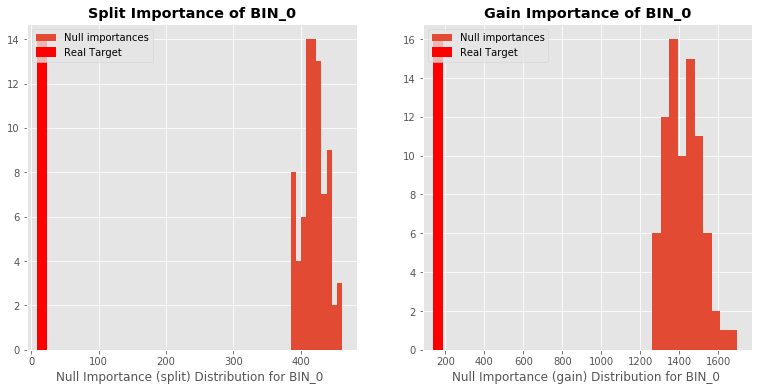

In [11]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='bin_0')

#### display_distributions - bin_1

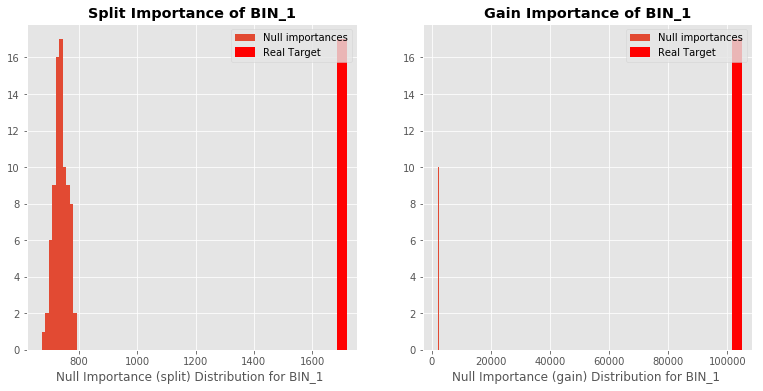

In [12]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='bin_1')

#### display_distributions - bin_2

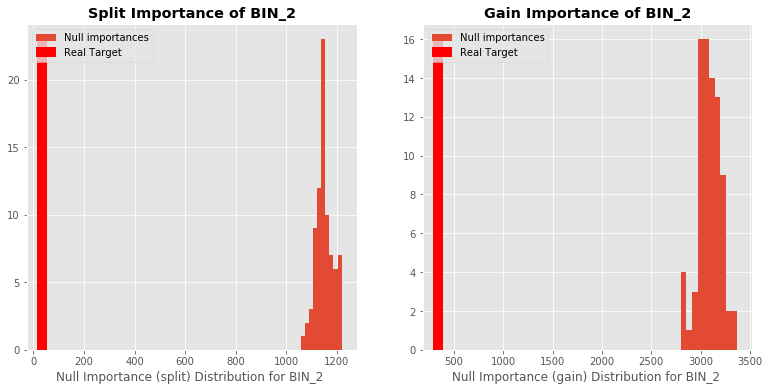

In [13]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='bin_2')

#### display_distributions - bin_3

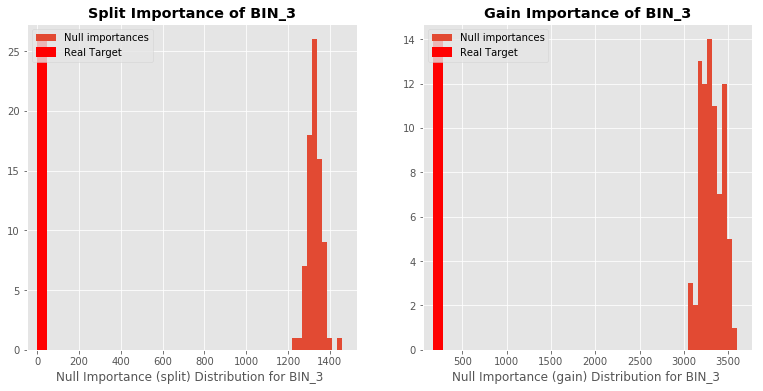

In [14]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='bin_3')

#### display_distributions - bin_4

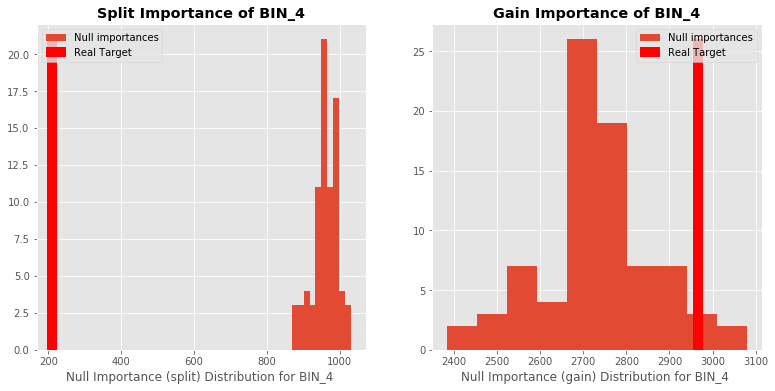

In [15]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='bin_4')

#### display_distributions - nom_1

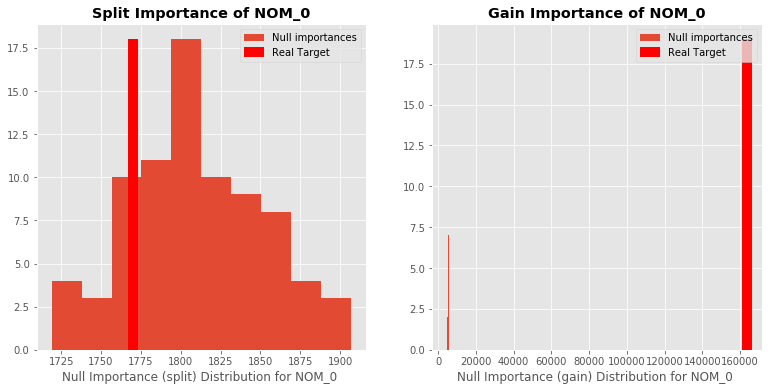

In [16]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_0')

#### display_distributions - nom_1

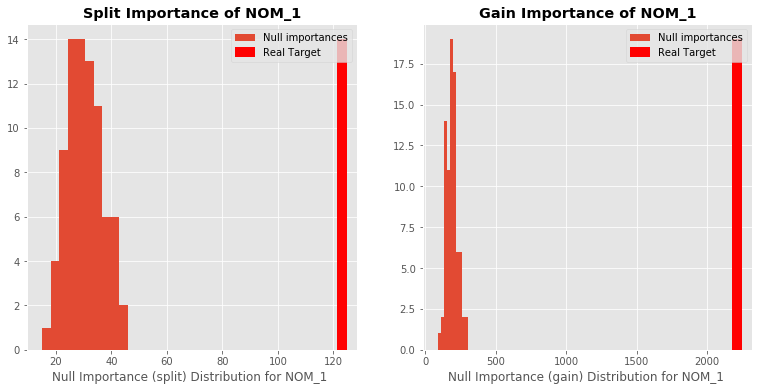

In [17]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_1')

#### display_distributions - nom_2

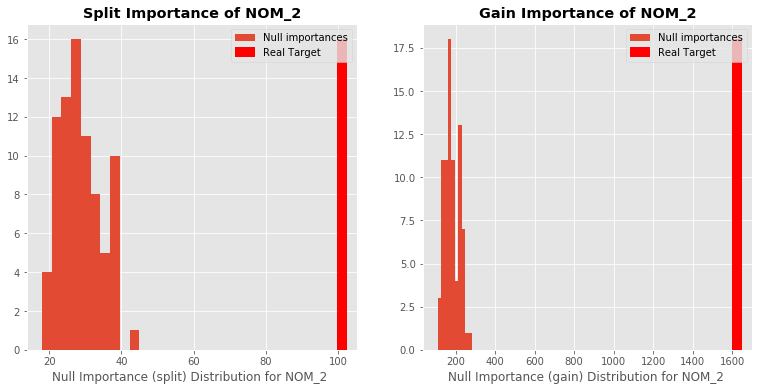

In [18]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_2')

#### display_distributions - nom_3

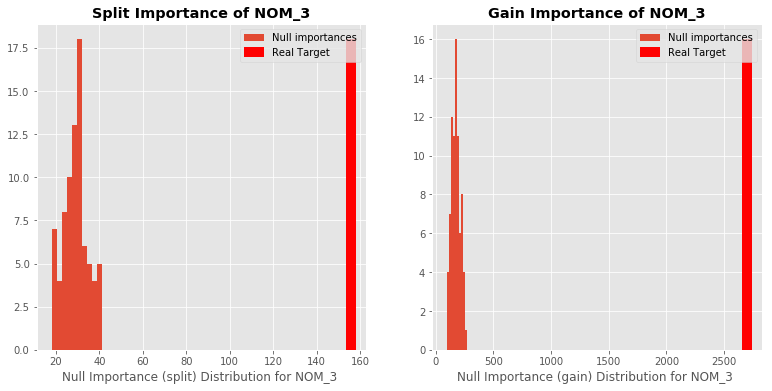

In [19]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_3')

#### display_distributions - nom_4

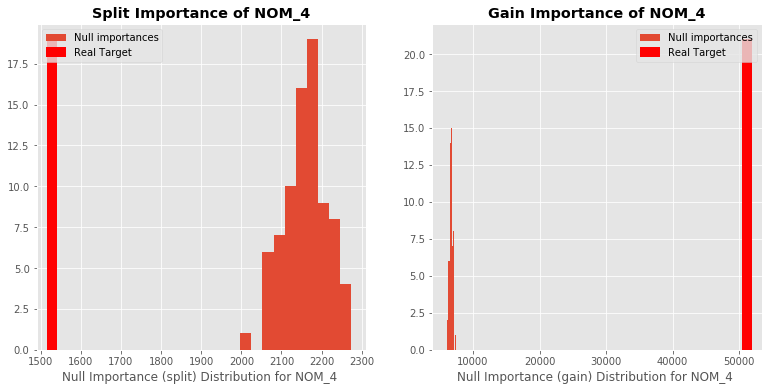

In [20]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_4')

#### display_distributions - nom_5

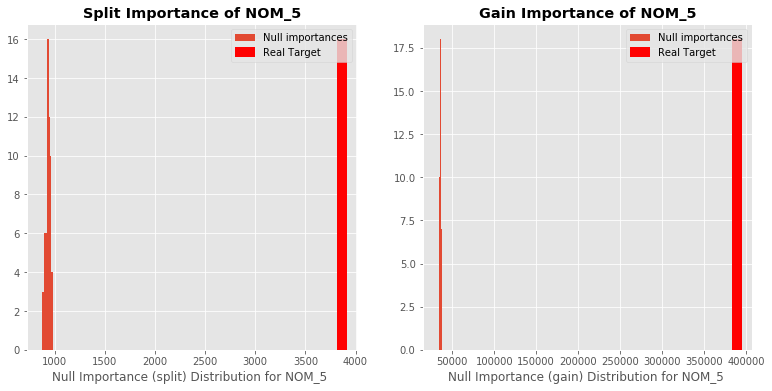

In [21]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_5')

#### display_distributions - nom_6

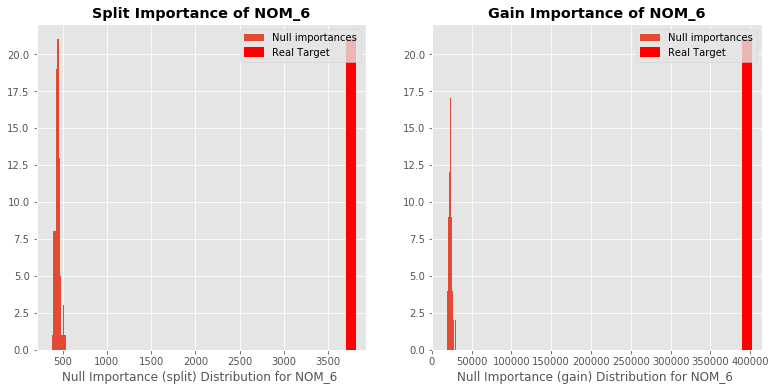

In [22]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_6')

#### display_distributions - nom_7

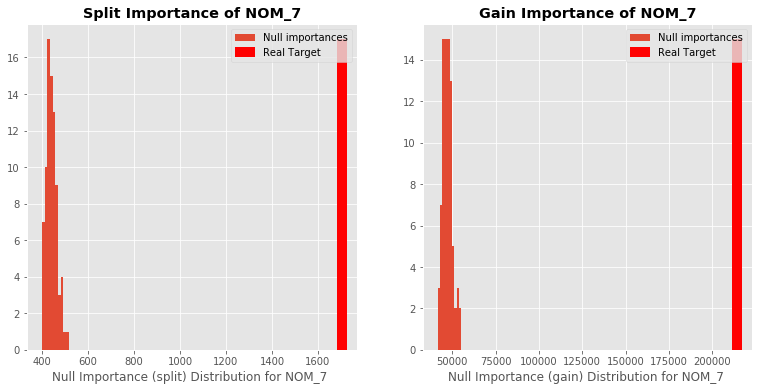

In [23]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_7')

#### display_distributions - nom_8

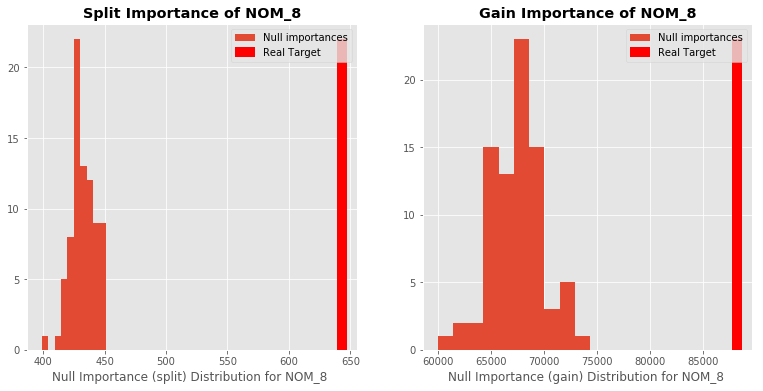

In [24]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_8')

#### display_distributions - nom_9

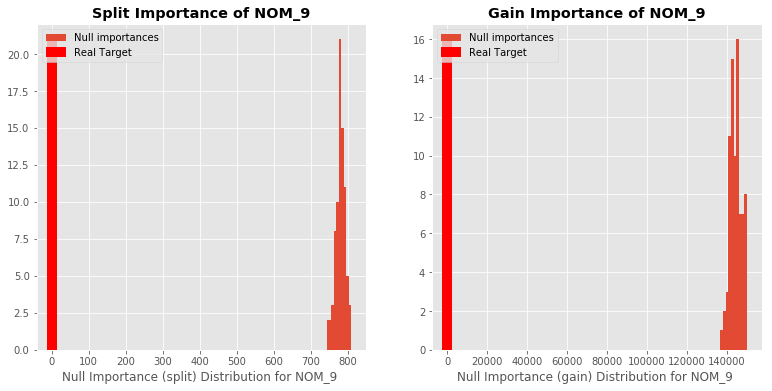

In [25]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='nom_9')

#### display_distributions - ord_0

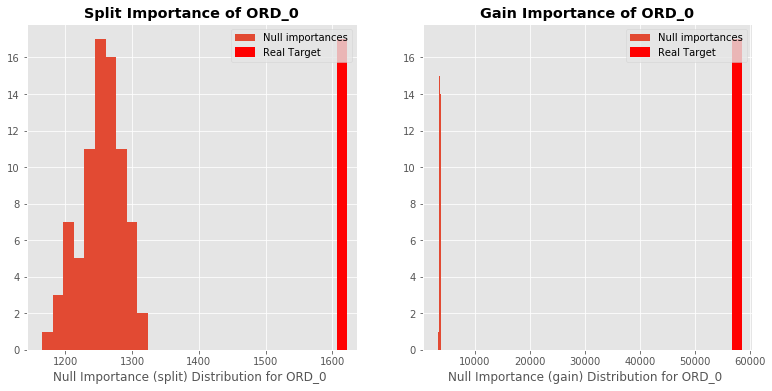

In [26]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ord_0')

#### display_distributions - ord_1

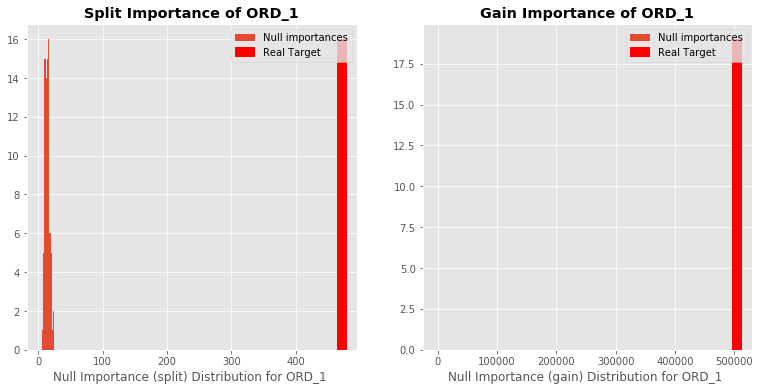

In [27]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ord_1')

#### display_distributions - ord_2

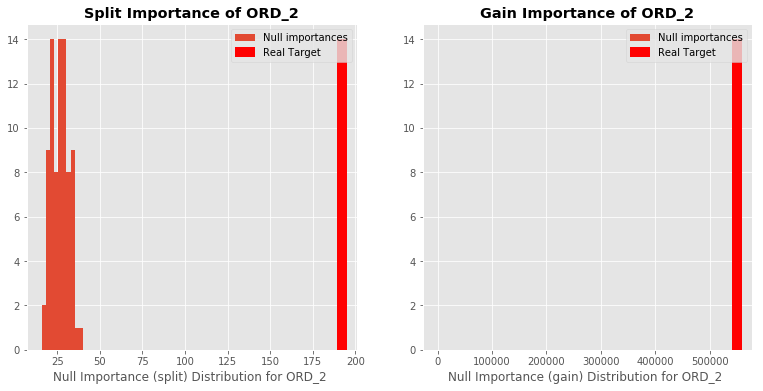

In [28]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ord_2')

#### display_distributions - ord_3

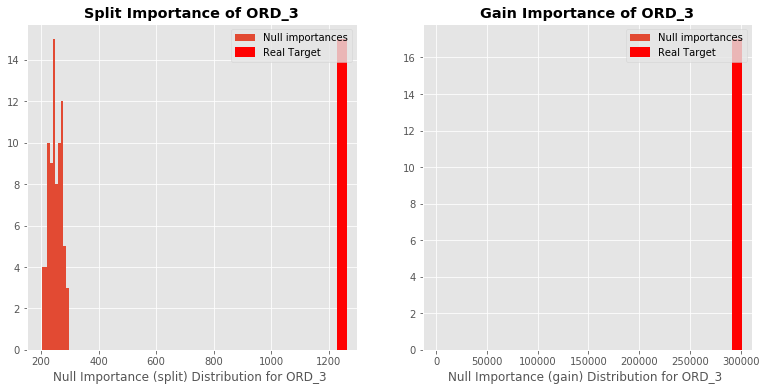

In [29]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ord_3')

#### display_distributions - ord_4

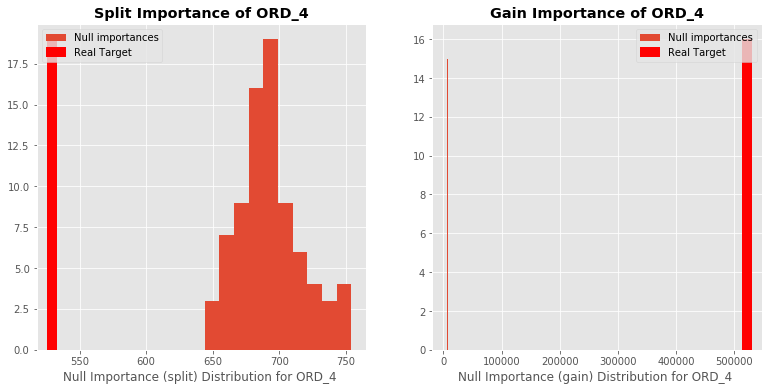

In [30]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ord_4')

#### display_distributions - ord_5

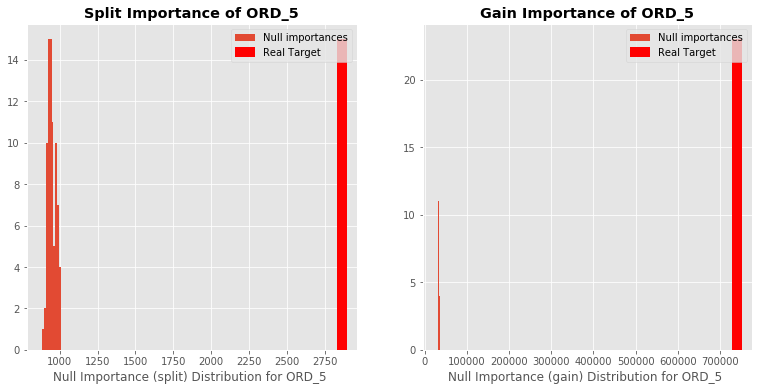

In [31]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ord_5')

#### display_distributions - day

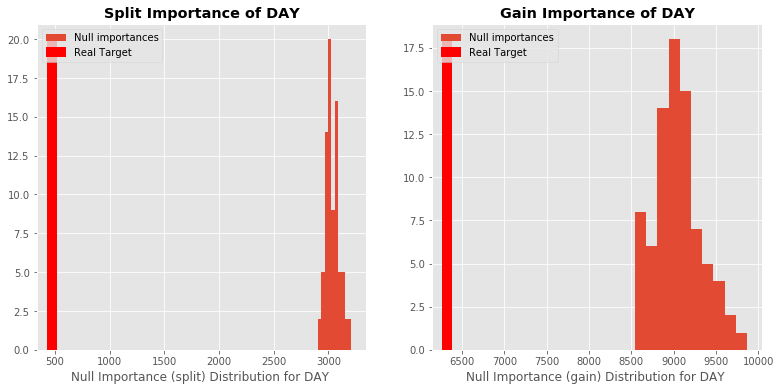

In [32]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='day')

#### display_distributions - month

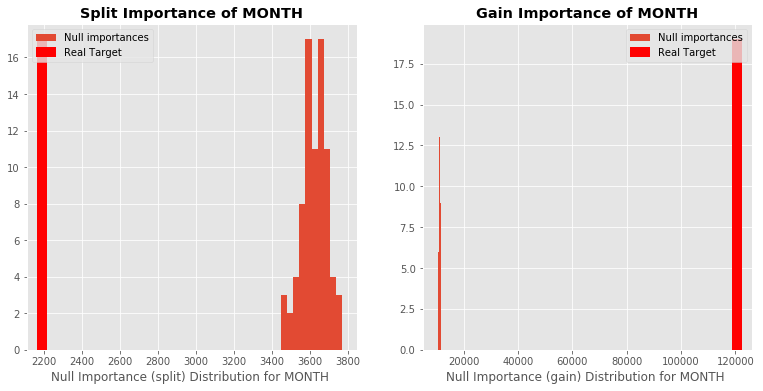

In [33]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='month')

CPU times: user 576 ms, sys: 4 ms, total: 580 ms
Wall time: 580 ms


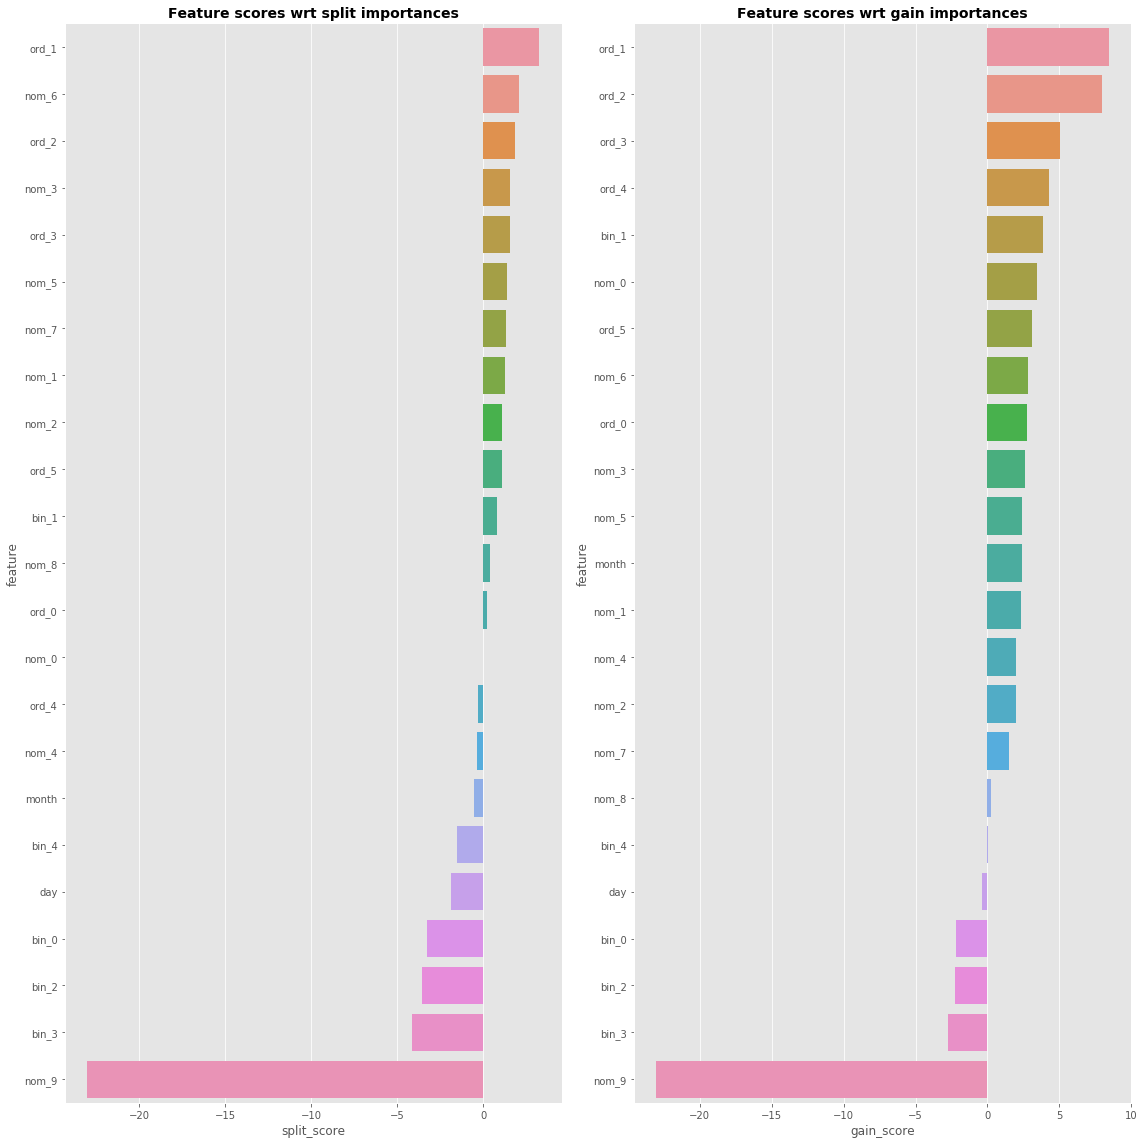

In [34]:
%%time
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

> Save data

In [35]:
# null_imp_df = pd.read_csv('null_importances_distribution_rf.csv')
# actual_imp_df = pd.read_csv('actual_importances_ditribution_rf.csv')

# actual_imp_df = actual_imp_df[['feature','importance_gain','importance_split','trn_score']].copy()
# null_imp_df = null_imp_df[['feature','importance_gain','importance_split','trn_score']].copy()

# Check the impact of removing uncorrelated features
> Here I'll use a different metric to asses correlation to the target

CPU times: user 504 ms, sys: 0 ns, total: 504 ms
Wall time: 502 ms


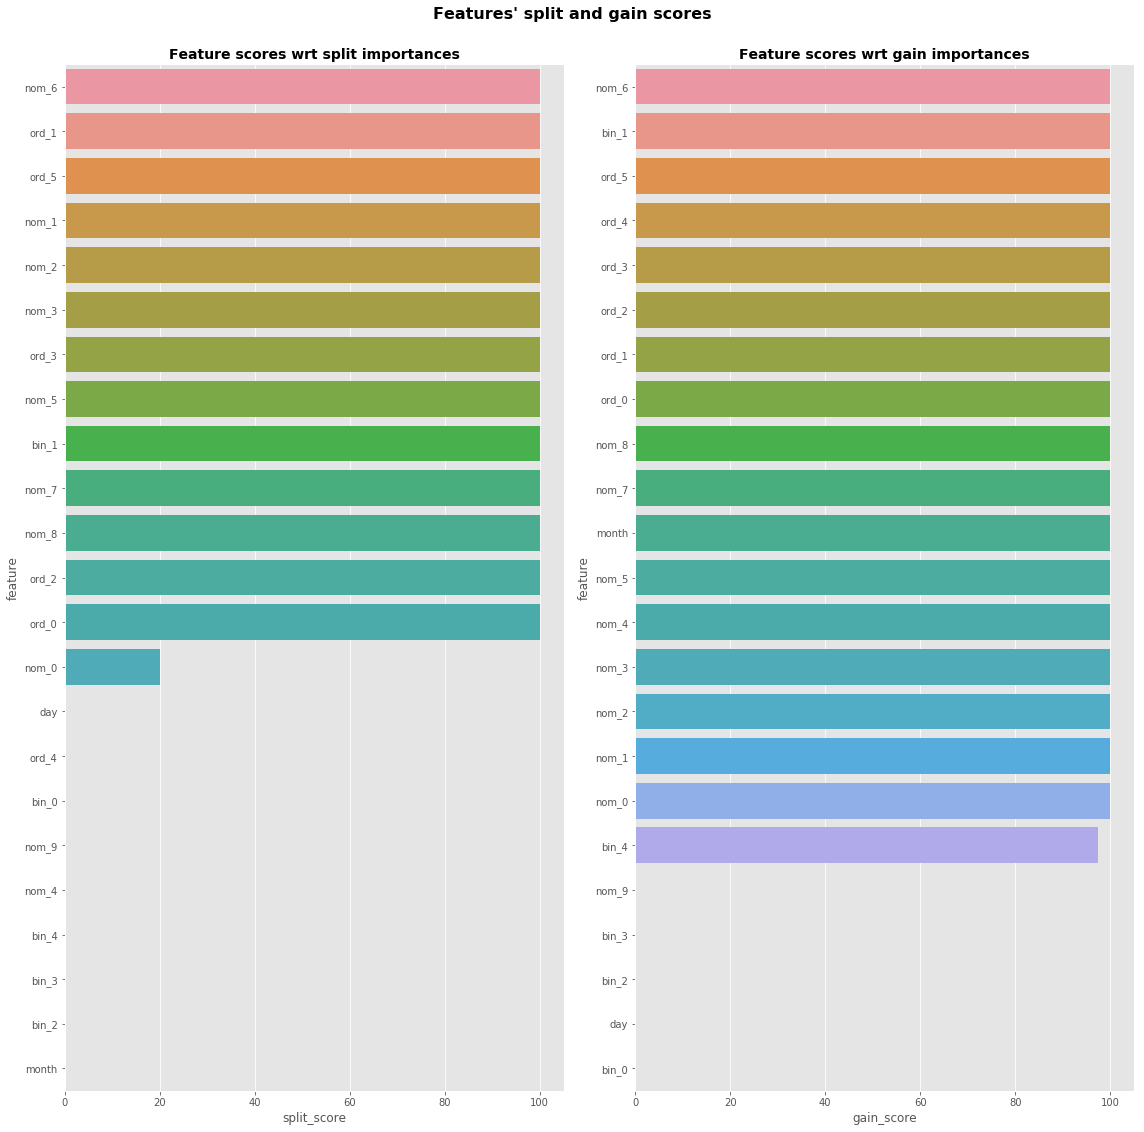

In [36]:
%%time
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

# Score feature removal for different thresholds

In [37]:
%%time
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

for threshold in [0, 5, 10, 15 ,20 , 25]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=train, train_features=split_feats, cat_feats=split_cat_feats, target=train['target'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=train, train_features=gain_feats, cat_feats=gain_cat_feats, target=train['target'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.784351 +/- 0.001959
	 GAIN  : 0.784351 +/- 0.001959
Results for threshold   5
	 SPLIT : 0.748361 +/- 0.001901
	 GAIN  : 0.780023 +/- 0.001901
Results for threshold  10
	 SPLIT : 0.748361 +/- 0.001901
	 GAIN  : 0.780023 +/- 0.001901
Results for threshold  15
	 SPLIT : 0.748361 +/- 0.001901
	 GAIN  : 0.780023 +/- 0.001901
Results for threshold  20
	 SPLIT : 0.748361 +/- 0.001901
	 GAIN  : 0.780023 +/- 0.001901
Results for threshold  25
	 SPLIT : 0.741343 +/- 0.001917
	 GAIN  : 0.780023 +/- 0.001901
CPU times: user 20min 32s, sys: 13 s, total: 20min 45s
Wall time: 5min 24s



<html>
<body>

<p><font size="5" color="blue">If you like my kernel please consider upvoting it</font></p>
<p><font size="4" color="purple">Remember the upvote button is next to the fork button, and it's free too! ;)</font></p>

</body>
</html>


# Final